## Geração e Divisão dos Dados

In [1]:
# Wevelet


import numpy as np
from sklearn.base import TransformerMixin
import pywt

class WaveletPackage(TransformerMixin):
  '''
  Extracts Wavelet Package features.
  The features are calculated by the energy of the recomposed signal
  of the leaf nodes coefficients.
  '''
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    def Energy(coeffs, k):
      return np.sqrt(np.sum(np.array(coeffs[-k]) ** 2)) / len(coeffs[-k])
    def getEnergy(wp):
      coefs = np.asarray([n.data for n in wp.get_leaf_nodes(True)])
      return np.asarray([Energy(coefs,i) for i in range(2**wp.maxlevel)])
    return np.array([getEnergy(pywt.WaveletPacket(data=x, wavelet='db4',
                                                  mode='symmetric', maxlevel=4)
                                                  ) for x in X[:]])

In [4]:
import numpy as np
from datasets import UORED

domains = {
    '1': ('H_1_0', 'I_1_1', 'O_6_1', 'B_11_1'),
    '2': ('H_2_0', 'I_1_2', 'O_6_2', 'B_11_2'),
    '3': ('H_3_0', 'I_2_1', 'O_7_1', 'B_12_1'),
    '4': ('H_4_0', 'I_2_2', 'O_7_2', 'B_12_2'),
    '5': ('H_5_0', 'I_3_1', 'O_8_1', 'B_13_1'),
    '6': ('H_6_0', 'I_3_2', 'O_8_2', 'B_13_2'),
    '7': ('H_7_0', 'I_4_1', 'O_9_1', 'B_14_1'),
    '8': ('H_8_0', 'I_4_2', 'O_9_2', 'B_14_2'),
    '9': ('H_9_0', 'I_5_1', 'O_10_1', 'B_15_1'),
    '10': ('H_10_0', 'I_5_2', 'O_10_2', 'B_15_2'),
}

train_domain = [(1, 3, 5, 7), (1, 3, 5, 9), (1, 3, 7, 9), 
                (1, 5, 7, 9), (3, 5, 7, 9), (2, 4, 6, 8), 
                (2, 4, 6, 10), (2, 4, 8, 10), (2, 6, 8, 10), (4, 5, 8, 10)]
test_domain = [9, 7, 5, 3, 1, 10, 8, 6, 4, 2]

def create_and_save_segments(filepath, output_path, max_allowed_sample_size=420_000, segment_size=420_000, transform=None, transform_segment=None):
    dataset = UORED()
    signal = dataset.load_file(filepath)[0]
    if transform is not None:
        signal = transform(signal)
    max_allowed_sample_size = len(signal)
    num_segments = max_allowed_sample_size//segment_size
    for i in range(num_segments):
        segment = signal[i*(segment_size):(i+1)*segment_size]
        if transform_segment is not None:
            segment = transform_segment(segment)
        np.save(f"{output_path}_{i}", segment)

### Segment sample

In [7]:
import numpy as np
import os
from datasets import UORED

classes = ("B", "I", "N", "O")
dsname_target = "uored_4096"
def save_npy_segments():
    root_dir = "data/raw/uored"
    for i, tr_domain in enumerate(train_domain):
        tr = [domains[str(t)] for t in tr_domain]
        ts = domains[str(test_domain[i])]
        # processing train data
        print(f"Round: {i+1}")
        for domain in tr: # [:-1]: # train
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/train/'
            os.makedirs(output_dir, exist_ok=True)
            for basename in domain:
                path = f"{root_dir}/{basename}"
                # output_path =  output_dir + ('N' if basename[0] == 'H' else basename[0]) + '/' + basename
                output_path = os.path.join(output_dir, basename.replace('H', 'N'))
                create_and_save_segments(path, output_path, segment_size=4096)
        # val
        # output_dir = root_dir.replace('raw', 'processed') + f'/setup_{i+1}/val/'
        # for basename in tr[-1]:
        #     path = f"{root_dir}/{basename}"
        #     output_path =  output_dir + ('N' if basename[0] == 'H' else basename[0]) + '/' + basename
        #     create_and_save_segments(path, output_path)
        # test
        for basename in ts: 
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/test/'
            os.makedirs(output_dir, exist_ok=True)
            path = f"{root_dir}/{basename}"
            # output_path =  output_dir + ('N' if basename[0] == 'H' else basename[0]) + '/' + basename
            output_path = os.path.join(output_dir, basename if basename[0]!='H' else basename.replace('H', 'N'))
            create_and_save_segments(path, output_path, segment_size=4096)


In [8]:
save_npy_segments()

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


### Segmentation to Hierarchical Classifier

In [ ]:
import numpy as np
import os


classes = ("B", "I", "N", "O")
dsname_target = "uored_wavelet"
def save_hierarchical_segments():
    root_dir = "data/raw/uored"
    for i, tr_domain in enumerate(train_domain):
        tr = [domains[str(t)] for t in tr_domain]
        ts = domains[str(test_domain[i])]
        # processing train data
        print(f"Round: {i+1}")
        for domain in tr: # train
            # BIN -> N x BIO
            """
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/bin/'
            os.makedirs(output_dir, exist_ok=True)
            for basename in domain:
                path = f"{root_dir}/{basename}"
                output_path = os.path.join(output_dir, basename.replace('H','N') if basename[0]=='H' else 'F_'+basename)
                create_and_save_segments(path, output_path, segment_size=1750)
            """        
            # BIN -> B x IO
            """
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/b_io/'
            os.makedirs(output_dir, exist_ok=True)
            for basename in domain:
                if basename[0] == 'H':
                    continue
                path = f"{root_dir}/{basename}"
                output_path = os.path.join(output_dir, basename if basename[0]=='B' else 'IO_'+basename)
                create_and_save_segments(path, output_path, segment_size=1750)
            """ 
            # BIN -> O x I
            """
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/i_o/'
            os.makedirs(output_dir, exist_ok=True)
            for basename in domain:
                if basename[0] in ['H', 'B']:
                    continue
                path = f"{root_dir}/{basename}"
                output_path = os.path.join(output_dir, basename)
                create_and_save_segments(path, output_path, segment_size=1750)
            """ 

            # BIO
            """
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/bio_aug/'
            os.makedirs(output_dir, exist_ok=True)
            for basename in domain:
                if basename[0]=='H':
                    continue
                path = f"{root_dir}/{basename}"
                output_path = os.path.join(output_dir, basename)
                create_and_save_segments(path, output_path, segment_size=1750)
            """

            # BINO
            """
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/bino_naug/'
            os.makedirs(output_dir, exist_ok=True)
            for basename in domain:
                path = f"{root_dir}/{basename}"
                output_path = os.path.join(output_dir, basename.replace('H', 'N'))
                create_and_save_segments(path, output_path, segment_size=1750)
            """

            # BINO with wavelet
            # """
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/tr_wavelet/'
            os.makedirs(output_dir, exist_ok=True)
            for basename in domain:
                path = f"{root_dir}/{basename}"
                output_path = os.path.join(output_dir, basename.replace('H', 'N'))
                create_and_save_segments(path, output_path, segment_size=2048)
            # """

        # VAL
        """
        output_dir = root_dir.replace('raw', 'processed') + f'/setup_{i+1}/val/'
        for basename in tr[-1]:
            path = f"{root_dir}/{basename}"
            output_path =  output_dir + ('N' if basename[0] == 'H' else basename[0]) + '/' + basename
            create_and_save_segments(path, output_path)
        """

        # BIN VAL
        """
        for basename in ts: 
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/bin_val/'
            os.makedirs(output_dir, exist_ok=True)
            path = f"{root_dir}/{basename}"
            output_path = os.path.join(output_dir, basename.replace('H', 'N') if basename[0]=='H' else 'F_'+basename)
            create_and_save_segments(path, output_path, segment_size=1750)
        """
        # TEST
        """
        for basename in ts: 
            output_dir = root_dir.replace('raw', 'processed').replace('uored', dsname_target) + f'/setup_{i+1}/test/'
            os.makedirs(output_dir, exist_ok=True)
            path = f"{root_dir}/{basename}"
            output_path = os.path.join(output_dir, basename if basename[0]!='H' else basename.replace('H', 'N'))
            create_and_save_segments(path, output_path, segment_size=1750)
        """

In [18]:
save_hierarchical_segments()

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


### Create Directories Structure 

In [8]:
# create structure
for label in ['B', 'I', 'N', 'O']:
    for mode in ['train', 'test']:
        for i in range(1, 11):
            os.makedirs(f'data/processed/uored_aug_only/setup_{i}/{mode}', exist_ok=True)

In [ ]:
root_dir = "data/processed/uored_aug_only"
for i in range(1, 11):
    for mode in ['train', 'test']:
        npy_root = f"{root_dir}/setup_{i}/{mode}"   # caminho de entrada
        out_root = npy_root.replace("processed", "spectrogram")  # saída das imagens
        np.save

### EMD

In [6]:
import emd
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt



def drop_last_if_residual(imf, fs, threshold_hz=0.5):
    """
    If the last IMF has near-zero median IF, treat it as residual and drop it.
    """
    _, IF, _ = emd.spectra.frequency_transform(imf, fs, 'hilbert')
    med_if = np.nanmedian(IF, axis=1)  # per-IMF median IF over time
    if med_if[-1] < threshold_hz and imf.shape[0] > 1:
        return imf[:-1, :]
    return imf

def ensure_imf_shape(imf, n_samples_expected):
    """
    Ensure IMFs are shaped as (n_imfs, n_samples).
    If we detect (n_samples, n_imfs), transpose them.
    """
    if imf.ndim == 1:
        # Only one trace returned (e.g., residual only) -> make it 2D
        imf = imf[np.newaxis, :]
    if imf.ndim != 2:
        raise ValueError(f"IMF must be 2D, got shape {imf.shape}")
    n0, n1 = imf.shape
    # Heuristic: if the first dim equals n_samples, it's likely (n_samples, n_imfs)
    if n0 == n_samples_expected and n1 != n_samples_expected:
        return imf.T
    return imf

def get_imfs_noise_assisted(x,
                            fs,
                            drop_res=True,
                            max_imfs=5,
                            nensembles=8,
                            ensemble_noise=0.2,
                            nprocesses=None,
                            imf_opts=None):
    """
    Run EEMD (ensemble_sift) with noise assistance and return IMFs shaped (n_imfs, n_samples).
    """
    if imf_opts is None:
        imf_opts = {}

    # --- FIX: coerce None -> 1 so emd doesn't do (None > 1) ---
    if nprocesses is None:
        nprocesses = 1

    imf = emd.sift.ensemble_sift(
        x,
        max_imfs=max_imfs,
        nensembles=nensembles,
        nprocesses=nprocesses,      # now guaranteed int
        ensemble_noise=ensemble_noise,
        imf_opts=imf_opts
    )

    imf = ensure_imf_shape(imf, n_samples_expected=x.size)

    if drop_res:
        imf = drop_last_if_residual(imf, fs)

    return imf


def plot_hht(mixed, output_path, fs=42000, freq_range=(0.5, 6_000, 120), sigma=1.0):
    """Plot a smoothed HHT of the mixed signal (skip if near-zero)."""

    N = len(mixed)               # 2048
    t = np.arange(N) / fs

    if mixed.size == 0 or np.allclose(mixed, 0.0) or np.std(mixed) < 1e-12:
        print("[Warn] Mixed is near-zero; skipping HHT.")
        return

    imf_mixed = get_imfs_noise_assisted(
        mixed, fs,
        drop_res=False,
        max_imfs=5,
        nensembles=8,
        ensemble_noise=0.2,
        nprocesses=None,
        imf_opts=None
    )
    _, IFm, IAm = emd.spectra.frequency_transform(imf_mixed, fs, 'hilbert')
    hht_f, hht = emd.spectra.hilberthuang(
        IFm, IAm, freq_range,
        mode='amplitude',
        sum_time=False
    )
    hht_smooth = gaussian_filter(hht, sigma)

    # Save borderless image
    plt.imshow(hht_smooth.T, origin='lower', aspect='auto',
               extent=[t[0], t[-1], hht_f[0], hht_f[-1]])
    plt.axis('off')  # remove axes
    plt.margins(0, 0)  # remove margins
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()


### Compose signal 1

In [6]:
import numpy as np

def _rms(x, eps=1e-12):
    return np.sqrt(np.mean(np.square(np.asarray(x)))) + eps

def compose_signals_fft(
    x,
    y,
    window=None,
    amp_mode="weighted",
    amp_weight=0.7,
    phase_mode="random",
    phase_mix_alpha=0.5,
    rng=None,
    rms_target="mean"
):
    
    x = np.load(x)
    y = np.load(y)
    x = np.asarray(x).astype(float, copy=False)
    y = np.asarray(y).astype(float, copy=False)
    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape.")
    if x.ndim != 1:
        raise ValueError("Expected 1D arrays.")

    N = x.shape[0]

    # Optional window
    if window is not None:
        if window.lower() == "hann":
            w = np.hanning(N)
        else:
            raise ValueError("Unsupported window type.")
        xw, yw = x * w, y * w
    else:
        xw, yw = x, y

    # FFT
    X = np.fft.rfft(xw)
    Y = np.fft.rfft(yw)

    magX, magY = np.abs(X), np.abs(Y)
    phiX, phiY = np.angle(X), np.angle(Y)

    # Magnitude combination
    if amp_mode == "sum":
        A = magX + magY
    elif amp_mode == "weighted":
        A = amp_weight * magX + (1.0 - amp_weight) * magY
    else:
        raise ValueError("amp_mode must be 'sum' or 'weighted'.")

    # Phase selection
    if phase_mode == "x":
        Phi = phiX
    elif phase_mode == "y":
        Phi = phiY
    elif phase_mode == "mix":
        Phi = phase_mix_alpha * phiX + (1.0 - phase_mix_alpha) * phiY
    elif phase_mode == "random":
        if rng is None:
            rng = np.random.default_rng()
        Phi = np.empty_like(phiX)
        pick_x = rng.random(size=phiX.shape) < 0.5
        Phi[pick_x] = phiX[pick_x]
        Phi[~pick_x] = phiY[~pick_x]
    else:
        raise ValueError("phase_mode must be 'x', 'y', 'mix', or 'random'.")

    # IFFT
    Z = A * np.exp(1j * Phi)
    z = np.fft.irfft(Z, n=N).real

    # RMS normalization
    if rms_target is not None:
        if rms_target == "mean":
            target = 0.5 * (_rms(x) + _rms(y))
        elif rms_target == "x":
            target = _rms(x)
        elif rms_target == "y":
            target = _rms(y)
        elif isinstance(rms_target, (int, float)):
            target = float(rms_target)
        else:
            raise ValueError("Invalid rms_target.")
        z = z / _rms(z) * target

    return z

### Superpose signals freq

In [13]:
import numpy as np

def superpose_signals_freq(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    # Ensure signals have the same length
    min_len = min(len(x1), len(x2))
    x1 = x1[:min_len]
    x2 = x2[:min_len]
    # FFT of both signals
    X1 = np.fft.fft(x1)
    X2 = np.fft.fft(x2)
    # Superpose in frequency domain (amplitude addition)
    X_combined = X1 + X2
    # Inverse FFT to get back to time domain
    x_combined = np.fft.ifft(X_combined)
    # Return real part (small imaginary parts come from numerical errors)
    return np.real(x_combined)

In [20]:
import numpy as np

domains = {
    '1': ('H_1_0', 'I_1_1', 'O_6_1', 'B_11_1'),
    '2': ('H_2_0', 'I_1_2', 'O_6_2', 'B_11_2'),
    '3': ('H_3_0', 'I_2_1', 'O_7_1', 'B_12_1'),
    '4': ('H_4_0', 'I_2_2', 'O_7_2', 'B_12_2'),
    '5': ('H_5_0', 'I_3_1', 'O_8_1', 'B_13_1'),
    '6': ('H_6_0', 'I_3_2', 'O_8_2', 'B_13_2'),
    '7': ('H_7_0', 'I_4_1', 'O_9_1', 'B_14_1'),
    '8': ('H_8_0', 'I_4_2', 'O_9_2', 'B_14_2'),
    '9': ('H_9_0', 'I_5_1', 'O_10_1', 'B_15_1'),
    '10': ('H_10_0', 'I_5_2', 'O_10_2', 'B_15_2'),
}

train_domain = [(1, 3, 5, 7), (1, 3, 5, 9), (1, 3, 7, 9), 
                (1, 5, 7, 9), (3, 5, 7, 9), (2, 4, 6, 8), 
                (2, 4, 6, 10), (2, 4, 8, 10), (2, 6, 8, 10), (4, 5, 8, 10)]
test_domain = [9, 7, 5, 3, 1, 10, 8, 6, 4, 2]


# root_dir = "data/processed/uored"
dsname_orig = "uored_hierarchical"
dsname_target = "uored_hierarchical"
for i, tr_domain in enumerate(train_domain):
    tr = [domains[str(t)] for t in tr_domain]
    # processing train data
    print(f"Round: {i+1}")
    data_map = {'B': [], 'I': [], 'N': [], 'O': []}
    for domain in tr: # train
        for basename in domain:
            if basename[0] == 'H':
                basename = basename.replace("H", "N")
            data_map[basename[0]].append(basename)
    for label in data_map:
        # label = 'N' if label == 'H' else label
        if label != 'N':
            continue
        base_x, base_y = data_map[label][0], data_map[label][2]
        for j in range(204):
            x_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_x}_{j}.npy"
            y_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_y}_{j}.npy"
            x = np.load(x_path)
            y = np.load(y_path)
            res1 = superpose_signals_freq(x, y)
            output_path = x_path.replace(dsname_orig, dsname_target).replace(base_x, f"{base_x}_{base_y}").replace('bino', 'bino_naug')
            np.save(output_path, res1)
        base_z, base_w = data_map[label][1], data_map[label][3]
        for j in range(204):
            z_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_z}_{j}.npy"
            w_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_w}_{j}.npy"
            z = np.load(z_path)
            w = np.load(w_path)
            res2 = superpose_signals_freq(z, w)
            output_path = z_path.replace(dsname_orig, dsname_target).replace(base_z, f"{base_z}_{base_w}").replace('bino', 'bino_naug')
            np.save(output_path, res2)

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


### Aumento de dados misturando o sinal

In [ ]:
import numpy as np

domains = {
    '1': ('H_1_0', 'I_1_1', 'O_6_1', 'B_11_1'),
    '2': ('H_2_0', 'I_1_2', 'O_6_2', 'B_11_2'),
    '3': ('H_3_0', 'I_2_1', 'O_7_1', 'B_12_1'),
    '4': ('H_4_0', 'I_2_2', 'O_7_2', 'B_12_2'),
    '5': ('H_5_0', 'I_3_1', 'O_8_1', 'B_13_1'),
    '6': ('H_6_0', 'I_3_2', 'O_8_2', 'B_13_2'),
    '7': ('H_7_0', 'I_4_1', 'O_9_1', 'B_14_1'),
    '8': ('H_8_0', 'I_4_2', 'O_9_2', 'B_14_2'),
    '9': ('H_9_0', 'I_5_1', 'O_10_1', 'B_15_1'),
    '10': ('H_10_0', 'I_5_2', 'O_10_2', 'B_15_2'),
}

train_domain = [(1, 3, 5, 7), (1, 3, 5, 9), (1, 3, 7, 9), 
                (1, 5, 7, 9), (3, 5, 7, 9), (2, 4, 6, 8), 
                (2, 4, 6, 10), (2, 4, 8, 10), (2, 6, 8, 10), (4, 5, 8, 10)]
test_domain = [9, 7, 5, 3, 1, 10, 8, 6, 4, 2]


# root_dir = "data/processed/uored"
dsname_orig = "uored_hierarchical"
dsname_target = "uored_hierarchical"
for i, tr_domain in enumerate(train_domain):
    tr = [domains[str(t)] for t in tr_domain]
    # processing train data
    print(f"Round: {i+1}")
    data_map = {'B': [], 'I': [], 'N': [], 'O': []}
    for domain in tr: # train
        for basename in domain:
            if basename[0] == 'H':
                basename = basename.replace("H", "N")
            data_map[basename[0]].append(basename)
    for label in data_map:
        # label = 'N' if label == 'H' else label
        if label != 'N':
            continue
        base_x, base_y = data_map[label][0], data_map[label][2]
        for j in range(204):
            x_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_x}_{j}.npy"
            y_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_y}_{j}.npy"
            x = np.load(x_path)
            y = np.load(y_path)
            res1 = superpose_signals_freq(x, y)
            output_path = x_path.replace(dsname_orig, dsname_target).replace(base_x, f"{base_x}_{base_y}").replace('bino', 'bino_naug')
            np.save(output_path, res1)
        base_z, base_w = data_map[label][1], data_map[label][3]
        for j in range(204):
            z_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_z}_{j}.npy"
            w_path = f"data/processed/{dsname_orig}/setup_{i+1}/bino/{base_w}_{j}.npy"
            z = np.load(z_path)
            w = np.load(w_path)
            res2 = superpose_signals_freq(z, w)
            output_path = z_path.replace(dsname_orig, dsname_target).replace(base_z, f"{base_z}_{base_w}").replace('bino', 'bino_naug')
            np.save(output_path, res2)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_line(x, fs=None, title="Signal (time domain)"):
    """
    Plot a 1D signal as a line chart.
    If fs is provided (>0), x-axis is time [s]; otherwise, sample index.
    """
    x = np.asarray(x).squeeze()

    plt.figure(figsize=(10, 3))

    if fs is not None and np.isfinite(fs) and fs > 0:
        t = np.arange(len(x), dtype=float) / float(fs)
        plt.plot(t, x, linewidth=1)
        plt.xlabel("Time [s]")
    else:
        plt.plot(x, linewidth=1)
        plt.xlabel("Samples")

    plt.ylabel("Amplitude")
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


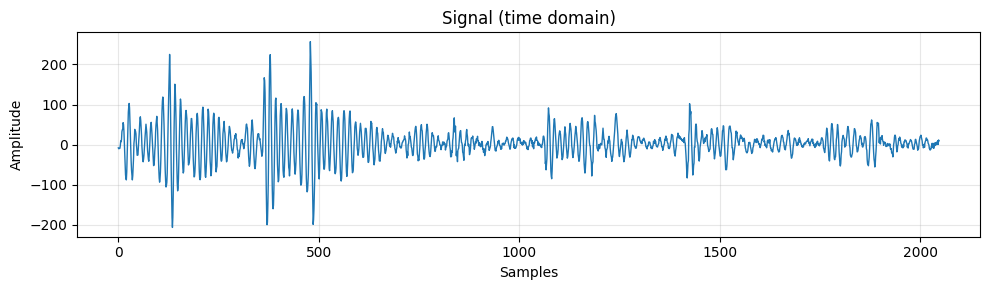

In [10]:
x = np.load("data/processed/uored/setup_1/train/B_11_1_0.npy")
plot_signal_line(x)


## Análise e Sobreposição de Sinais

In [1]:
import numpy as np
from scipy.signal import get_window

# -----------------------------
# Utility: RMS normalization
# -----------------------------
def rms_normalize(x, eps=1e-12, target_rms=1.0):
    """
    Normalize 1D signal to target RMS.
    """
    x = np.asarray(x, dtype=np.float64)
    rms = np.sqrt(np.mean(x**2) + eps)
    return (x / rms) * target_rms

# -----------------------------
# FDM-like band design (Algorithm C)
# -----------------------------
def make_fdm_bands(fs, m=1.5, fmin=0.0, fmax=None, max_bands=10):
    """
    Create FDM bands using Algorithm C from the paper:
      1) fH1 = fs/2, f_c = ((2m-1)/(2m+1)) * fH
      2) next fH <- f_c and repeat
    Returns a list of (f_low, f_high) in Hz, high→low order.
    The last leftover below the lowest band is the residual (optional to use).
    """
    if fmax is None:
        fmax = fs / 2.0
    ratio = (2.0 * m - 1.0) / (2.0 * m + 1.0)  # in (0,1)
    bands = []

    fH = float(fmax)
    for _ in range(max_bands):
        fL = ratio * fH
        if fL <= fmin or (fH - fL) < 1e-6:
            break
        bands.append((fL, fH))
        fH = fL

    return bands  # [(fL1,fH1), (fL2,fH2), ...]

# -----------------------------
# Zero-phase filtering in FFT domain (real signals)
# -----------------------------
def rfft_band_mask(n, fs, f_low, f_high):
    """
    Create a [0..N/2] RFFT boolean mask selecting frequencies in [f_low, f_high].
    """
    freqs = np.fft.rfftfreq(n, d=1.0/fs)  # Hz
    mask = (freqs >= f_low) & (freqs <= f_high)
    return mask

def zero_phase_bandpass_fft(x, fs, f_low, f_high):
    """
    Zero-phase bandpass filtering via RFFT masking.
    """
    x = np.asarray(x, dtype=np.float64)
    n = x.shape[0]
    X = np.fft.rfft(x)
    mask = rfft_band_mask(n, fs, f_low, f_high)
    Y = np.zeros_like(X)
    Y[mask] = X[mask]
    y = np.fft.irfft(Y, n=n)
    return y

# -----------------------------
# FDM-like decomposition (bands aligned)
# -----------------------------
def fdm_decompose(x, fs, m=1.5, max_bands=10, use_residual=True):
    """
    Decompose signal into FDM-like bands (high → low) using zero-phase filtering.
    Returns:
      bands: list of (fL, fH)
      components: list of time-domain components per band (same length as x)
      residual: low-frequency residual (below the lowest band), or None
    """
    x = np.asarray(x, dtype=np.float64)
    n = x.shape[0]
    bands = make_fdm_bands(fs, m=m, fmax=fs/2.0, max_bands=max_bands)
    components = []

    # Extract each band by masking in frequency domain
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    accum = np.zeros_like(X)

    for (fL, fH) in bands:
        band_mask = (freqs >= fL) & (freqs <= fH)
        Y = np.zeros_like(X)
        Y[band_mask] = X[band_mask]
        y = np.fft.irfft(Y, n=n)
        components.append(y)
        accum[band_mask] = X[band_mask]  # accumulate energy we've “explained”

    residual = None
    if use_residual:
        # Anything below the lowest band's fL (or any unselected bin) is residual
        Yres = X - accum
        residual = np.fft.irfft(Yres, n=n)

    return bands, components, residual

# -----------------------------
# Frequency-domain mixing
# -----------------------------
def mix_frequency_simple(x1, x2, fs, alpha=0.5, beta=0.5, rms_pre_norm=True, out_rms=None):
    """
    Simple frequency-domain sum: Xmix = alpha*X1 + beta*X2, then IFFT.
    Optionally RMS-normalize inputs before mixing and scale output to out_rms.
    """
    x1 = np.asarray(x1, dtype=np.float64)
    x2 = np.asarray(x2, dtype=np.float64)
    n = min(len(x1), len(x2))
    x1 = x1[:n]
    x2 = x2[:n]

    if rms_pre_norm:
        x1 = rms_normalize(x1, target_rms=1.0)
        x2 = rms_normalize(x2, target_rms=1.0)

    X1 = np.fft.rfft(x1)
    X2 = np.fft.rfft(x2)
    Xmix = alpha * X1 + beta * X2
    xmix = np.fft.irfft(Xmix, n=n)

    if out_rms is not None:
        xmix = rms_normalize(xmix, target_rms=float(out_rms))
    return xmix

def mix_frequency_by_band(x1, x2, fs, m=1.5, max_bands=10, weights=None, rms_pre_norm=True, out_rms=None):
    """
    FDM-aligned band-wise mixing: for each (fL,fH), combine spectra with per-band weights.
    weights: list of tuples (alpha_i, beta_i) per band (same length as bands). If None, use (0.5,0.5).
    """
    x1 = np.asarray(x1, dtype=np.float64)
    x2 = np.asarray(x2, dtype=np.float64)
    n = min(len(x1), len(x2))
    x1 = x1[:n]
    x2 = x2[:n]

    if rms_pre_norm:
        x1 = rms_normalize(x1, target_rms=1.0)
        x2 = rms_normalize(x2, target_rms=1.0)

    bands = make_fdm_bands(fs, m=m, fmax=fs/2.0, max_bands=max_bands)
    X1 = np.fft.rfft(x1)
    X2 = np.fft.rfft(x2)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    Xmix = np.zeros_like(X1, dtype=np.complex128)

    if weights is None:
        weights = [(0.5, 0.5) for _ in bands]
    assert len(weights) == len(bands), "weights length must match number of bands"

    # Combine per band
    for (fL, fH), (a, b) in zip(bands, weights):
        band_mask = (freqs >= fL) & (freqs <= fH)
        Xmix[band_mask] = a * X1[band_mask] + b * X2[band_mask]

    # Optionally copy the very low residual (below the last band's fL) from a chosen source:
    if len(bands) > 0:
        lowest_fL = bands[-1][0]
        low_mask = (freqs < lowest_fL)
        # choose 100% from x1 for residual; you may change to x2 or a mix
        Xmix[low_mask] = X1[low_mask]

    xmix = np.fft.irfft(Xmix, n=n)
    if out_rms is not None:
        xmix = rms_normalize(xmix, target_rms=float(out_rms))
    return xmix, bands

def mix_frequency_random_superposition(x1, x2, fs, p=0.5, rms_pre_norm=True, out_rms=None, seed=None):
    """
    Random superposition in the frequency domain:
      For each RFFT bin, pick X1 or X2 with probability p (X1) or (1-p) (X2).
    This preserves phase continuity within each chosen source per-bin.
    """
    rng = np.random.default_rng(seed)
    x1 = np.asarray(x1, dtype=np.float64)
    x2 = np.asarray(x2, dtype=np.float64)
    n = min(len(x1), len(x2))
    x1 = x1[:n]
    x2 = x2[:n]

    if rms_pre_norm:
        x1 = rms_normalize(x1, target_rms=1.0)
        x2 = rms_normalize(x2, target_rms=1.0)

    X1 = np.fft.rfft(x1)
    X2 = np.fft.rfft(x2)

    choose_X1 = rng.random(X1.shape) < float(p)
    Xmix = np.where(choose_X1, X1, X2)

    xmix = np.fft.irfft(Xmix, n=n)
    if out_rms is not None:
        xmix = rms_normalize(xmix, target_rms=float(out_rms))
    return xmix

# -----------------------------
# Convenience: windowing (optional but recommended)
# -----------------------------
def apply_tukey(x, alpha=0.0):
    """
    Optional: apply a Tukey window to reduce spectral leakage (alpha=0 -> rectangular).
    """
    x = np.asarray(x, dtype=np.float64)
    w = get_window(("tukey", float(alpha)), x.shape[0], fftbins=False)
    return x * w


In [9]:
# Example with synthetic data: replace with your .npy files
fs = 42000.0
t = np.arange(0, 0.25, 1.0/fs)  # 250 ms

# Synthetic bearing-like tones + noise (for demonstration)
x1 = 0.8*np.sin(2*np.pi*1200*t) + 0.5*np.sin(2*np.pi*3600*t) + 0.1*np.random.randn(t.size)
x2 = 0.6*np.sin(2*np.pi*1800*t) + 0.7*np.sin(2*np.pi*4800*t) + 0.1*np.random.randn(t.size)

# (A) Simple frequency sum
xmix_simple = mix_frequency_simple(x1, x2, fs, alpha=0.6, beta=0.4, rms_pre_norm=True, out_rms=1.0)

# (B) Band-wise mixing with FDM-aligned bands
# Example: emphasize high bands from x2 and low bands from x1
bands = make_fdm_bands(fs, m=1.5, max_bands=6)
# Create weights: for the first 3 (higher) bands, favor x2; for the last 3, favor x1
weights = []
for i, _ in enumerate(bands):
    if i < 3:
        weights.append((0.3, 0.7))  # alpha for x1, beta for x2
    else:
        weights.append((0.7, 0.3))
xmix_bands, used_bands = mix_frequency_by_band(x1, x2, fs, m=1.5, max_bands=6, weights=weights, rms_pre_norm=True, out_rms=1.0)

# (C) Random superposition per-bin
xmix_rand = mix_frequency_random_superposition(x1, x2, fs, p=0.5, rms_pre_norm=True, out_rms=1.0, seed=42)

# Print quick sanity checks
def _rms(v): return float(np.sqrt(np.mean(np.asarray(v)**2)))
print("[RMS] x1:", _rms(x1), "x2:", _rms(x2))
print("[RMS] mix_simple:", _rms(xmix_simple))
print("[RMS] mix_bands:", _rms(xmix_bands))
print("[RMS] mix_rand:", _rms(xmix_rand))
print("Bands used (Hz):", used_bands)


[RMS] x1: 0.6739007270842495 x2: 0.658688967290173
[RMS] mix_simple: 0.9999999999990378
[RMS] mix_bands: 0.9999999999992816
[RMS] mix_rand: 0.9999999999994188
Bands used (Hz): [(10500.0, 21000.0), (5250.0, 10500.0), (2625.0, 5250.0), (1312.5, 2625.0), (656.25, 1312.5), (328.125, 656.25)]


Usando com os dados de rolamentos

In [6]:
import numpy as np

def _rms(v): return float(np.sqrt(np.mean(np.asarray(v)**2)))

fs = 48000.0

x1 = np.load("data/processed/uored/setup_1/train/B/B_13_1_10.npy").astype(float)
x2 = np.load("data/processed/uored/setup_1/train/B/B_11_1_262.npy").astype(float)

# (1) Soma simples no domínio da frequência (com normalização RMS de entrada)
xmix = mix_frequency_simple(x1, x2, fs, alpha=0.5, beta=0.5, rms_pre_norm=True, out_rms=1.0)

# (2) Mistura por bandas FDM (exemplo com pesos iguais)
xmix_bands, bands = mix_frequency_by_band(x1, x2, fs, m=1.5, max_bands=8, weights=None, rms_pre_norm=True, out_rms=1.0)

# (3) Random superposition por bin de frequência
xmix_rand = mix_frequency_random_superposition(x1, x2, fs, p=0.5, rms_pre_norm=True, out_rms=1.0, seed=0)

np.save("mix_simple.npy", xmix)
np.save("mix_bands.npy", xmix_bands)
np.save("mix_random.npy", xmix_rand)
print("Saved: mix_simple.npy, mix_bands.npy, mix_random.npy")
print(_rms(xmix), _rms(xmix_bands), _rms(xmix_rand), _rms(x1), _rms(x2))


Saved: mix_simple.npy, mix_bands.npy, mix_random.npy
0.999999999999065 0.9999999999990554 0.9999999999994575 39.49463173666255 22.308528345825085


In [ ]:
print()
print("[RMS] x1:", _rms(x1), "x2:", _rms(x2))
print("[RMS] mix_simple:", _rms(xmix_simple))
print("[RMS] mix_bands:", _rms(xmix_bands))
print("[RMS] mix_rand:", _rms(xmix_rand))
print("Bands used (Hz):", used_bands)


[1.36800227 1.05593002 0.57415977 ... 0.15178173 1.05920453 2.1475819 ]


In [ ]:
# run_mix_verbose.py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ========= USER CONFIG =========
fs = 48000.0
path_x1 = "sinal1.npy"
path_x2 = "sinal2.npy"
save_prefix = "mix"            # prefixo dos arquivos de saída
do_plots = True                # coloque False se não quiser plots
stft_nfft = 2048               # para o gráfico STFT
stft_nperseg = 1024
stft_noverlap = 896
# ===============================

def db(x, eps=1e-12):
    return 20.0 * np.log10(np.maximum(eps, x))

def describe_signal(name, x, fs):
    n = len(x)
    dur = n / fs
    rms = float(np.sqrt(np.mean(x**2)))
    peak = float(np.max(np.abs(x)))
    crest = peak / (rms if rms > 0 else 1.0)
    print(f"[{name}] length={n} | duration={dur:.3f}s | RMS={rms:.6f} | peak={peak:.6f} | crest={crest:.3f}")

def plot_time(name, x, fs, max_seconds=0.02):
    n = len(x)
    m = min(n, int(max_seconds * fs))
    t = np.arange(m) / fs
    plt.figure()
    plt.plot(t, x[:m])
    plt.title(f"{name} - time (first {max_seconds*1000:.0f} ms)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.tight_layout()

def plot_spectrum(name, x, fs):
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(len(x), 1.0/fs)
    mag = np.abs(X)
    plt.figure()
    plt.semilogy(freqs, mag)
    plt.title(f"{name} - |X(f)| (RFFT)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("|X(f)|")
    plt.tight_layout()

def plot_stft(name, x, fs, nperseg, noverlap, nfft):
    # STFT simples com matplotlib.specgram (equivalente, sem seaborn)
    plt.figure()
    Pxx, freqs, bins, im = plt.specgram(
        x, NFFT=nperseg, Fs=fs, noverlap=noverlap, pad_to=nfft, scale_by_freq=False
    )
    plt.title(f"{name} - STFT (specgram)")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.tight_layout()

def main():
    # Load
    if not Path(path_x1).exists() or not Path(path_x2).exists():
        print("Erro: verifique os caminhos path_x1/path_x2.")
        return
    x1 = np.load(path_x1).astype(float)
    x2 = np.load(path_x2).astype(float)

    # Ajustar ao mesmo tamanho
    n = min(len(x1), len(x2))
    x1 = x1[:n]
    x2 = x2[:n]

    print("======== INPUTS ========")
    describe_signal("x1 (raw)", x1, fs)
    describe_signal("x2 (raw)", x2, fs)

    # Preview (opcional)
    if do_plots:
        plot_time("x1", x1, fs)
        plot_time("x2", x2, fs)
        plot_spectrum("x1", x1, fs)
        plot_spectrum("x2", x2, fs)

    # ---------- (1) Mix simples ----------
    print("\n======== MIX SIMPLE ========")
    xmix_simple = mix_frequency_simple(
        x1, x2, fs, alpha=0.5, beta=0.5, rms_pre_norm=True, out_rms=1.0
    )
    describe_signal("mix_simple", xmix_simple, fs)
    np.save(f"{save_prefix}_simple.npy", xmix_simple)

    if do_plots:
        plot_time("mix_simple", xmix_simple, fs)
        plot_spectrum("mix_simple", xmix_simple, fs)
        plot_stft("mix_simple", xmix_simple, fs, stft_nperseg, stft_noverlap, stft_nfft)

    # ---------- (2) Mix por bandas ----------
    print("\n======== MIX BY BANDS (FDM) ========")
    # Mostrar bandas que serão usadas
    bands = make_fdm_bands(fs, m=1.5, max_bands=8)
    print("Bandas FDM (Hz) high→low:")
    for i, (fL, fH) in enumerate(bands, 1):
        print(f"  Band {i:02d}: [{fL:.1f}, {fH:.1f}] Hz  (BW={fH-fL:.1f})")

    xmix_bands, used_bands = mix_frequency_by_band(
        x1, x2, fs, m=1.5, max_bands=8, weights=None, rms_pre_norm=True, out_rms=1.0
    )
    describe_signal("mix_bands", xmix_bands, fs)
    np.save(f"{save_prefix}_bands.npy", xmix_bands)

    if do_plots:
        plot_time("mix_bands", xmix_bands, fs)
        plot_spectrum("mix_bands", xmix_bands, fs)
        plot_stft("mix_bands", xmix_bands, fs, stft_nperseg, stft_noverlap, stft_nfft)

    # ---------- (3) Random superposition ----------
    print("\n======== MIX RANDOM SUPERPOSITION ========")
    xmix_rand = mix_frequency_random_superposition(
        x1, x2, fs, p=0.5, rms_pre_norm=True, out_rms=1.0, seed=42
    )
    describe_signal("mix_random", xmix_rand, fs)
    np.save(f"{save_prefix}_random.npy", xmix_rand)

    if do_plots:
        plot_time("mix_random", xmix_rand, fs)
        plot_spectrum("mix_random", xmix_rand, fs)
        plot_stft("mix_random", xmix_rand, fs, stft_nperseg, stft_noverlap, stft_nfft)

    print("\nArquivos salvos:")
    print(f"  {save_prefix}_simple.npy")
    print(f"  {save_prefix}_bands.npy")
    print(f"  {save_prefix}_random.npy")

    if do_plots:
        plt.show()

if __name__ == "__main__":
    main()


# Utilizando EMD na sobreposição de frenquências

In [18]:
# ------------------------------------------------------------
# EMD-based frequency-overlap / mixing with robust shape checks
# ------------------------------------------------------------
# Requirements:
#   pip install emd numpy matplotlib scipy
#
# What this does:
# 1) Generates two example signals (replace with your data if needed)
# 2) Runs EMD (sift) on each signal
# 3) Computes instantaneous frequency (IF) and amplitude (IA) per IMF
# 4) Matches IMFs by median IF (within tolerance)
# 5) Mixes only matched IMFs and reconstructs a composite signal
# 6) Plots results + optional HHT of the mixed signal
#
# Notes:
# - If your EMD returns IMFs shaped (n_samples, n_imfs), we transpose.
# - We ensure mixing creates a time trace with the same length as t.

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import signal as sp_sig
import emd



# -----------------------
# Helpers
# -----------------------
def ensure_imf_shape(imf, n_samples_expected):
    """
    Ensure IMFs are shaped as (n_imfs, n_samples).
    If we detect (n_samples, n_imfs), transpose them.
    """
    if imf.ndim != 2:
        raise ValueError(f"IMF must be 2D, got shape {imf.shape}")
    n0, n1 = imf.shape
    # Heuristic: if the first dim equals n_samples, it's likely (n_samples, n_imfs)
    if n0 == n_samples_expected and n1 != n_samples_expected:
        return imf.T
    return imf

def drop_last_if_residual(imf, fs, threshold_hz=0.5):
    """
    If the last IMF has near-zero median IF, treat it as residual and drop it.
    """
    IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')
    med_if = np.nanmedian(IF, axis=1)  # per-IMF median IF
    if med_if[-1] < threshold_hz:
        return imf[:-1, :]
    return imf

def sift_and_prepare(x, fs, drop_res=True):
    """
    Run sift, fix shape to (n_imfs, n_samples), and optionally drop residual.
    """
    imf = emd.sift.sift(x)
    imf = ensure_imf_shape(imf, n_samples_expected=x.size)
    if drop_res:
        imf = drop_last_if_residual(imf, fs)
    return imf

def match_imfs_by_median_if(imf1, imf2, fs, tol_hz):
    """
    Compute IF for both IMF sets and match IMFs by closest median IF,
    enforcing 1-1 pairing within a given tolerance.
    Returns: list of (i, j) pairs and the arrays of median IFs.
    """
    IP1, IF1, IA1 = emd.spectra.frequency_transform(imf1, fs, 'hilbert')
    IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, fs, 'hilbert')

    med_if1 = np.nanmedian(IF1, axis=1)
    med_if2 = np.nanmedian(IF2, axis=1)

    # initial greedy pairing
    raw_pairs = []
    for i, f1 in enumerate(med_if1):
        j = np.argmin(np.abs(med_if2 - f1))
        if np.abs(med_if2[j] - f1) <= tol_hz:
            raw_pairs.append((i, j))

    # enforce 1-1 by keeping the closest first
    pairs = []
    used_j = set()
    for i, j in sorted(raw_pairs, key=lambda p: abs(med_if1[p[0]] - med_if2[p[1]])):
        if j not in used_j:
            pairs.append((i, j))
            used_j.add(j)

    return pairs, med_if1, med_if2

def mix_by_pairs(imf1, imf2, pairs, n_samples):
    """
    Sum matched IMFs into a single time-domain mixed signal.
    """
    mixed_components = []
    for i, j in pairs:
        # Each IMF trace must be (n_samples,)
        comp = imf1[i, :] + imf2[j, :]
        mixed_components.append(comp)

    if mixed_components:
        mixed = np.sum(np.vstack(mixed_components), axis=0)
    else:
        mixed = np.zeros(n_samples, dtype=float)

    return mixed


def plot_emd(s1, s2, mixed):
    # -----------------------
    # 5) Plots
    # -----------------------
    plt.figure(figsize=(12, 7))
    plt.subplot(3,1,1)
    plt.plot(t, s1, lw=1)
    plt.title("Signal 1")
    plt.xlabel("Time [s]"); plt.ylabel("Amp")

    plt.subplot(3,1,2)
    plt.plot(t, s2, lw=1)
    plt.title("Signal 2")
    plt.xlabel("Time [s]"); plt.ylabel("Amp")

    plt.subplot(3,1,3)
    plt.plot(t, mixed, lw=1.5)
    plt.title("Mixed (sum of matched IMFs by median IF)")
    plt.xlabel("Time [s]"); plt.ylabel("Amp")
    plt.tight_layout()
    plt.show()


# -----------------------
# 6) (Optional) HHT of the mixed signal to inspect TF content
# -----------------------
def plot_hht(mixed):
    imf_mixed = sift_and_prepare(mixed, fs, drop_res=False)
    IPm, IFm, IAm = emd.spectra.frequency_transform(imf_mixed, fs, 'hilbert')
    freq_range = (0.5, 80, 60)  # (fmin, fmax, n_bins) – adjust as needed
    hht_f, hht = emd.spectra.hilberthuang(IFm, IAm, freq_range, mode='amplitude', sum_time=False)
    hht_smooth = gaussian_filter(hht, 1.0)

    plt.figure(figsize=(10, 4))
    plt.imshow(hht_smooth.T, origin='lower', aspect='auto',
            extent=[t[0], t[-1], hht_f[0], hht_f[-1]])
    plt.colorbar(label='Amplitude')
    plt.title("HHT (mixed signal)")
    plt.xlabel("Time [s]"); plt.ylabel("Frequency [Hz]")
    plt.tight_layout()
    plt.show()

def superposition(s1, s2, fs, DROP_RESIDUAL, IF_TOL_HZ):
    # -----------------------
    # 2) EMD and preparation
    # -----------------------
    imf1 = sift_and_prepare(s1, fs, drop_res=DROP_RESIDUAL)
    imf2 = sift_and_prepare(s2, fs, drop_res=DROP_RESIDUAL)

    # safety checks
    assert imf1.ndim == 2 and imf2.ndim == 2
    assert imf1.shape[1] == t.size and imf2.shape[1] == t.size

    print("imf1 shape:", imf1.shape, "imf2 shape:", imf2.shape, "t shape:", t.shape)

    # -----------------------
    # 3) Match IMFs by median IF
    # -----------------------
    pairs, med_if1, med_if2 = match_imfs_by_median_if(imf1, imf2, fs, IF_TOL_HZ)

    print("\nMatched IMF pairs (imf1_idx -> imf2_idx) with median IFs:")
    for i, j in pairs:
        print(f"  {i} -> {j} | IF1≈{med_if1[i]:.2f} Hz, IF2≈{med_if2[j]:.2f} Hz")

    # -----------------------
    # 4) Mix matched IMFs
    # -----------------------
    mixed = mix_by_pairs(imf1, imf2, pairs, n_samples=t.size)

    # safety check before plotting
    assert mixed.shape == t.shape, f"mixed shape {mixed.shape} != t shape {t.shape}"

    plot_emd(s1, s2, mixed)
    plot_hht(mixed)


In [21]:
# -----------------------
# 0) Config
# -----------------------
fs = 42000
duration = 1.0
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
IF_TOL_HZ = 100.0   # tolerance to decide “similar frequency” IMFs
DROP_RESIDUAL = True  # drop last IMF if it looks like residual (very low IF)

(42000,) (42000,)
imf1 shape: (10, 42000) imf2 shape: (6, 42000) t shape: (42000,)

Matched IMF pairs (imf1_idx -> imf2_idx) with median IFs:
  9 -> 4 | IF1≈-87.73 Hz, IF2≈0.00 Hz


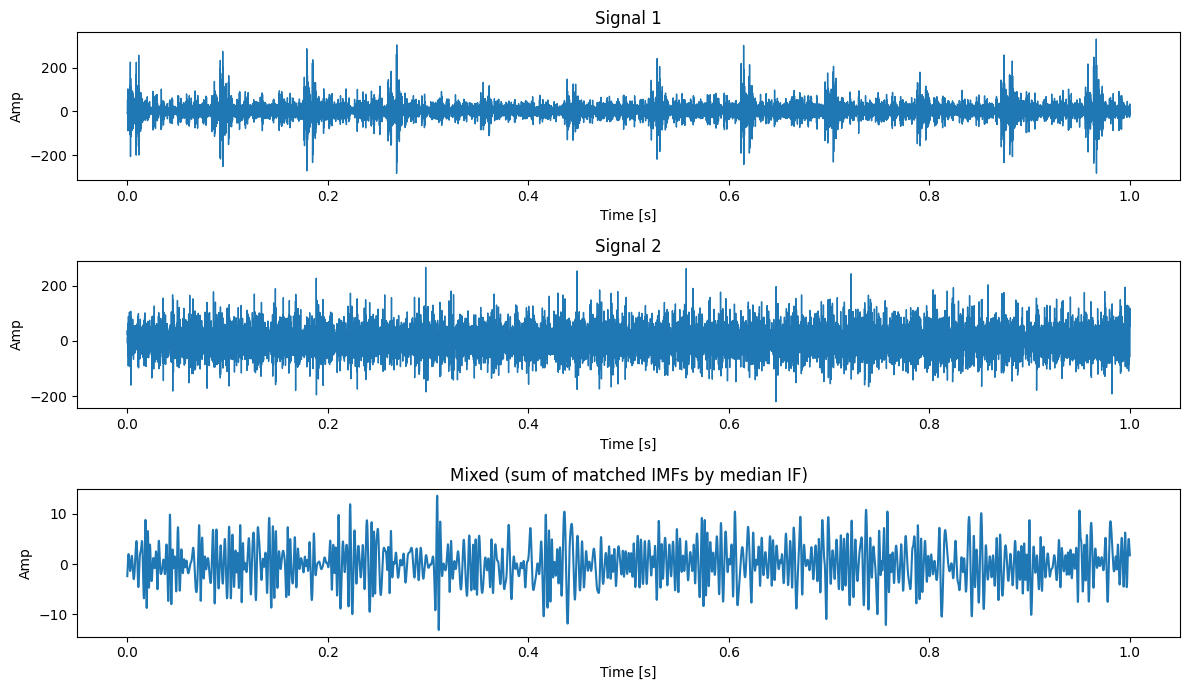

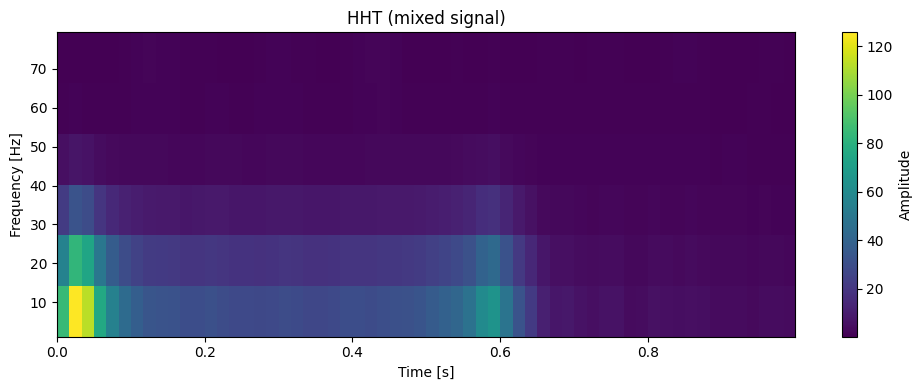

In [22]:
# -----------------------
# 1) Build two example signals
#    (Replace s1, s2 by your real signals with same fs)
# -----------------------
from datasets import UORED
ds = UORED()
s1 = ds.load_file("data/raw/uored/B_11_1.mat")[0][:42000]
s2 = ds.load_file("data/raw/uored/B_13_1.mat")[0][:42000]
print(s1.shape, s2.shape)
superposition(s1, s2, fs, DROP_RESIDUAL, IF_TOL_HZ)


In [ ]:
# ------------------------------------------------------------
# EEMD-based frequency-overlap / mixing with robust shape checks
# (uses emd.sift.ensemble_sift for noise-assisted sifting)
# ------------------------------------------------------------
# Requirements:
#   pip install emd numpy matplotlib scipy
#
# This module:
# 1) Decomposes each input signal with EEMD (ensemble_sift)
# 2) Computes instantaneous frequency/amplitude (Hilbert)
# 3) Matches IMFs by median IF (within a tolerance)
# 4) Mixes only matched IMFs into a composite time trace
# 5) Optional HHT plotting of the mixed signal
#
# Notes:
# - Limit max_imfs to keep ensemble averaging consistent.
# - Avoid global state; pass 't' (time vector) explicitly to plotting.
# - Includes guards for “no pairs” or near-zero mixed signal.

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import emd


# -----------------------
# Helpers
# -----------------------
def ensure_imf_shape(imf, n_samples_expected):
    """
    Ensure IMFs are shaped as (n_imfs, n_samples).
    If we detect (n_samples, n_imfs), transpose them.
    """
    if imf.ndim == 1:
        # Only one trace returned (e.g., residual only) -> make it 2D
        imf = imf[np.newaxis, :]
    if imf.ndim != 2:
        raise ValueError(f"IMF must be 2D, got shape {imf.shape}")
    n0, n1 = imf.shape
    # Heuristic: if the first dim equals n_samples, it's likely (n_samples, n_imfs)
    if n0 == n_samples_expected and n1 != n_samples_expected:
        return imf.T
    return imf


def drop_last_if_residual(imf, fs, threshold_hz=0.5):
    """
    If the last IMF has near-zero median IF, treat it as residual and drop it.
    """
    _, IF, _ = emd.spectra.frequency_transform(imf, fs, 'hilbert')
    med_if = np.nanmedian(IF, axis=1)  # per-IMF median IF over time
    if med_if[-1] < threshold_hz and imf.shape[0] > 1:
        return imf[:-1, :]
    return imf


def get_imfs_noise_assisted(x,
                            fs,
                            drop_res=True,
                            max_imfs=5,
                            nensembles=8,
                            ensemble_noise=0.2,
                            nprocesses=None,
                            imf_opts=None):
    """
    Run EEMD (ensemble_sift) with noise assistance and return IMFs shaped (n_imfs, n_samples).
    """
    if imf_opts is None:
        imf_opts = {}

    # --- FIX: coerce None -> 1 so emd doesn't do (None > 1) ---
    if nprocesses is None:
        nprocesses = 1

    imf = emd.sift.ensemble_sift(
        x,
        max_imfs=max_imfs,
        nensembles=nensembles,
        nprocesses=nprocesses,      # now guaranteed int
        ensemble_noise=ensemble_noise,
        imf_opts=imf_opts
    )

    imf = ensure_imf_shape(imf, n_samples_expected=x.size)

    if drop_res:
        imf = drop_last_if_residual(imf, fs)

    return imf



def match_imfs_by_median_if(imf1, imf2, fs, tol_hz, band=None):
    """
    Compute IF for both IMF sets and match IMFs by closest median IF,
    enforcing 1-1 pairing within a given tolerance.

    Args:
        imf1, imf2: arrays (n_imfs, n_samples)
        fs: sampling rate
        tol_hz: max allowed difference between median IFs
        band: optional (fmin, fmax) to restrict matching to a band of interest

    Returns:
        pairs: list of (i, j) indices
        med_if1, med_if2: arrays of median IFs (Hz)
    """
    _, IF1, _ = emd.spectra.frequency_transform(imf1, fs, 'hilbert')
    _, IF2, _ = emd.spectra.frequency_transform(imf2, fs, 'hilbert')

    med_if1 = np.nanmedian(IF1, axis=1)
    med_if2 = np.nanmedian(IF2, axis=1)

    idx1 = np.arange(med_if1.size)
    idx2 = np.arange(med_if2.size)

    if band is not None:
        fmin, fmax = band
        mask1 = (med_if1 >= fmin) & (med_if1 <= fmax)
        mask2 = (med_if2 >= fmin) & (med_if2 <= fmax)
        idx1 = idx1[mask1]
        idx2 = idx2[mask2]

    # Build candidate pairs (greedy by nearest IF2)
    raw_pairs = []
    for i in idx1:
        j = idx2[np.argmin(np.abs(med_if2[idx2] - med_if1[i]))] if idx2.size else None
        if j is not None and np.abs(med_if2[j] - med_if1[i]) <= tol_hz:
            raw_pairs.append((i, j))

    # Enforce 1-1 pairing by keeping the closest first
    pairs = []
    used_j = set()
    for i, j in sorted(raw_pairs, key=lambda p: abs(med_if1[p[0]] - med_if2[p[1]])):
        if j not in used_j:
            pairs.append((i, j))
            used_j.add(j)

    return pairs, med_if1, med_if2


def mix_by_pairs(imf1, imf2, pairs, n_samples):
    """
    Sum matched IMFs into a single time-domain mixed signal.
    """
    mixed_components = []
    for i, j in pairs:
        comp = imf1[i, :] + imf2[j, :]
        mixed_components.append(comp)

    if mixed_components:
        mixed = np.sum(np.vstack(mixed_components), axis=0)
    else:
        mixed = np.zeros(n_samples, dtype=float)

    return mixed


# -----------------------
# Plotting
# -----------------------
def plot_emd(t, s1, s2, mixed):
    """Plot the two input signals and the mixed output."""
    plt.figure(figsize=(12, 7))
    plt.subplot(3, 1, 1)
    plt.plot(t, s1, lw=1)
    plt.title("Signal 1")
    plt.xlabel("Time [s]"); plt.ylabel("Amp")

    plt.subplot(3, 1, 2)
    plt.plot(t, s2, lw=1)
    plt.title("Signal 2")
    plt.xlabel("Time [s]"); plt.ylabel("Amp")

    plt.subplot(3, 1, 3)
    plt.plot(t, mixed, lw=1.5)
    plt.title("Mixed (sum of matched IMFs by median IF)")
    plt.xlabel("Time [s]"); plt.ylabel("Amp")
    plt.tight_layout()
    plt.show()


def plot_hht(t, mixed, fs, freq_range=(0.5, 80, 60), sigma=1.0, title="HHT (mixed signal)"):
    """Plot a smoothed HHT of the mixed signal (skip if near-zero)."""
    if mixed.size == 0 or np.allclose(mixed, 0.0) or np.std(mixed) < 1e-12:
        print("[Warn] Mixed is near-zero; skipping HHT.")
        return

    imf_mixed = get_imfs_noise_assisted(
        mixed, fs,
        drop_res=False,
        max_imfs=5,
        nensembles=8,
        ensemble_noise=0.2,
        nprocesses=None,
        imf_opts=None
    )
    _, IFm, IAm = emd.spectra.frequency_transform(imf_mixed, fs, 'hilbert')
    hht_f, hht = emd.spectra.hilberthuang(
        IFm, IAm, freq_range,
        mode='amplitude',
        sum_time=False
    )
    hht_smooth = gaussian_filter(hht, sigma)

    plt.figure(figsize=(10, 4))
    plt.imshow(hht_smooth.T, origin='lower', aspect='auto',
               extent=[t[0], t[-1], hht_f[0], hht_f[-1]])
    plt.colorbar(label='Amplitude')
    plt.title(title)
    plt.xlabel("Time [s]"); plt.ylabel("Frequency [Hz]")
    plt.tight_layout()
    plt.show()


# -----------------------
# Main API
# -----------------------
def superposition(
    s1, s2, fs, t,
    IF_TOL_HZ=20.0,
    DROP_RESIDUAL=True,
    BAND=None,  # e.g., (5.0, 5000.0) to restrict matching
    # EEMD parameters:
    MAX_IMFS=5,
    NENSEMBLES=8,
    ENSEMBLE_NOISE=0.2,
    NPROCESSES=None,
    IMF_OPTS=None,
    plot_hht_flag=True
):
    """
    Perform EEMD-based IMF matching and superposition.

    Args:
        s1, s2: input time signals (same length)
        fs: sampling rate (Hz)
        t: time vector (same length as s1/s2)
        IF_TOL_HZ: frequency tolerance for IMF pairing
        DROP_RESIDUAL: drop residual-like last IMF
        BAND: optional (fmin, fmax) to restrict pairing
        MAX_IMFS, NENSEMBLES, ENSEMBLE_NOISE, NPROCESSES, IMF_OPTS: EEMD controls
        plot_hht_flag: whether to compute/plot HHT of mixed

    Returns:
        mixed: composite signal
        pairs: list of matched IMF indices
        med_if1, med_if2: median IF arrays for inspection
    """
    assert s1.shape == s2.shape == t.shape, "s1, s2, t must have the same shape"

    # 1) EEMD decomposition for both signals
    imf1 = get_imfs_noise_assisted(
        s1, fs,
        drop_res=DROP_RESIDUAL,
        max_imfs=MAX_IMFS,
        nensembles=NENSEMBLES,
        ensemble_noise=ENSEMBLE_NOISE,
        nprocesses=NPROCESSES,
        imf_opts=IMF_OPTS
    )
    imf2 = get_imfs_noise_assisted(
        s2, fs,
        drop_res=DROP_RESIDUAL,
        max_imfs=MAX_IMFS,
        nensembles=NENSEMBLES,
        ensemble_noise=ENSEMBLE_NOISE,
        nprocesses=NPROCESSES,
        imf_opts=IMF_OPTS
    )

    print("imf1 shape:", imf1.shape, "imf2 shape:", imf2.shape, "t shape:", t.shape)

    # 2) Match IMFs by median IF (optionally restricted to a band)
    pairs, med_if1, med_if2 = match_imfs_by_median_if(
        imf1, imf2, fs, tol_hz=IF_TOL_HZ, band=BAND
    )

    print("\nMatched IMF pairs (imf1_idx -> imf2_idx) with median IFs:")
    for i, j in pairs:
        print(f"  {i} -> {j} | IF1≈{med_if1[i]:.2f} Hz, IF2≈{med_if2[j]:.2f} Hz")

    # 3) Mix only matched IMFs
    mixed = mix_by_pairs(imf1, imf2, pairs, n_samples=t.size)

    # 4) Plots
    plot_emd(t, s1, s2, mixed)

    if plot_hht_flag and pairs and not np.allclose(mixed, 0.0) and np.std(mixed) >= 1e-12:
        plot_hht(t, mixed, fs)
        plot_hht(s1, mixed, fs)
        plot_hht(s2, mixed, fs)
    else:
        print("[Info] Skipping HHT (no pairs or near-zero mixed).")

    return mixed, pairs, med_if1, med_if2


imf1 shape: (4, 42000) imf2 shape: (4, 42000) t shape: (42000,)


/home/Adriano/cwru-autoencoder-diagnosis/env/lib/python3.8/site-packages/scipy/signal/_signaltools.py:1551: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '



Matched IMF pairs (imf1_idx -> imf2_idx) with median IFs:
  2 -> 2 | IF1≈0.00 Hz, IF2≈0.00 Hz
  3 -> 3 | IF1≈0.00 Hz, IF2≈0.00 Hz


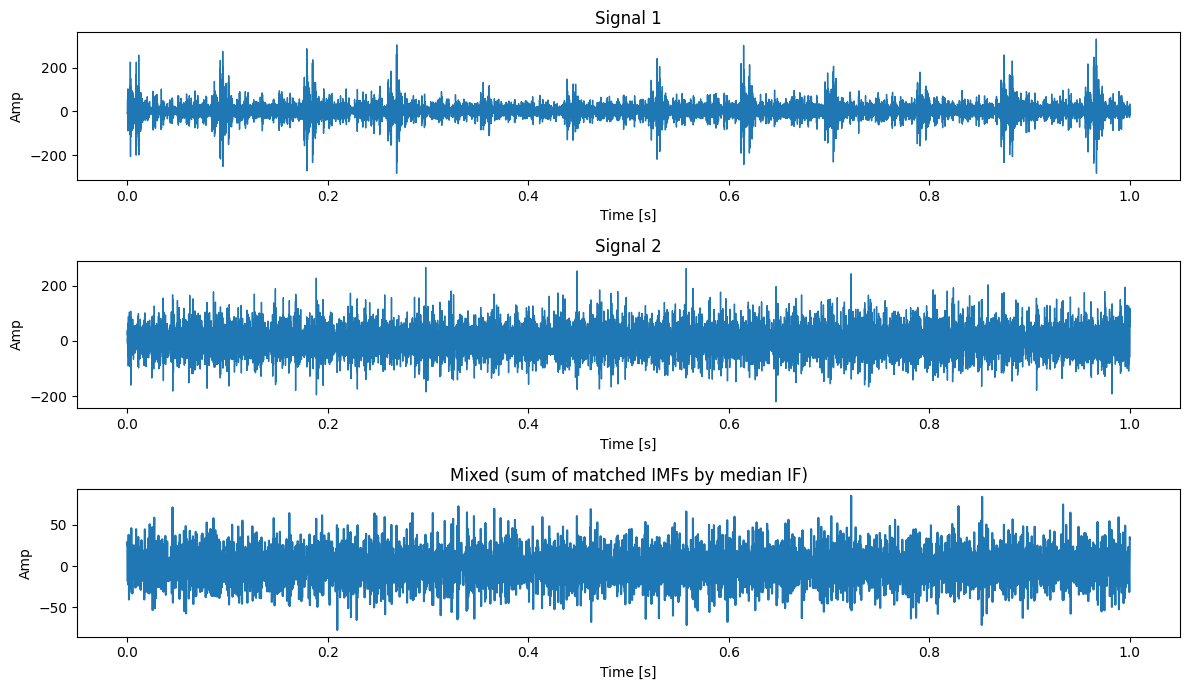

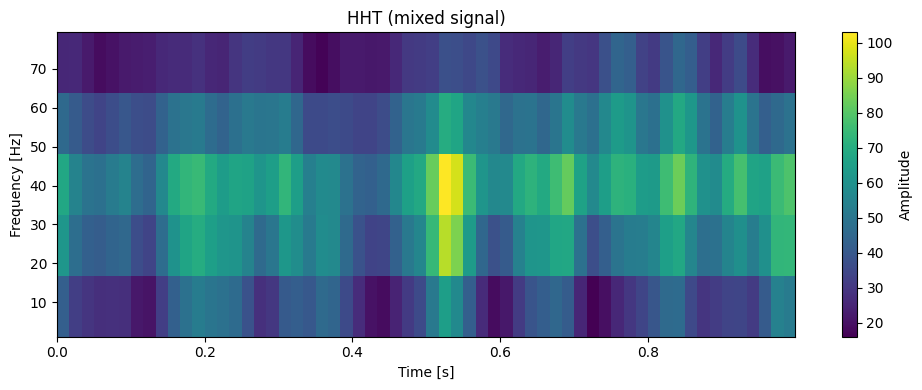

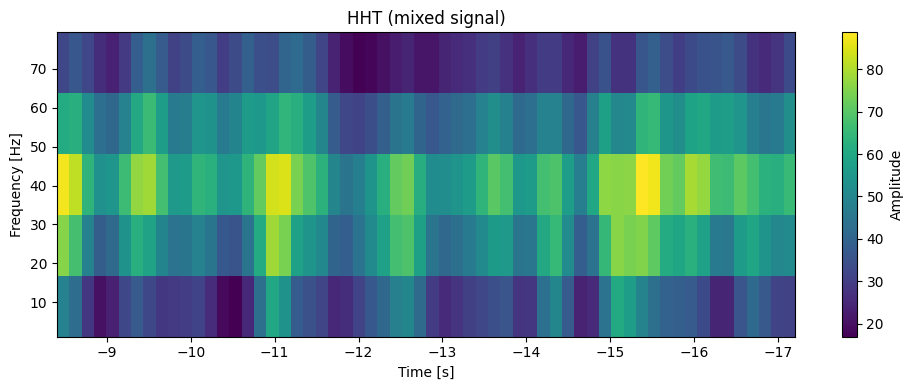

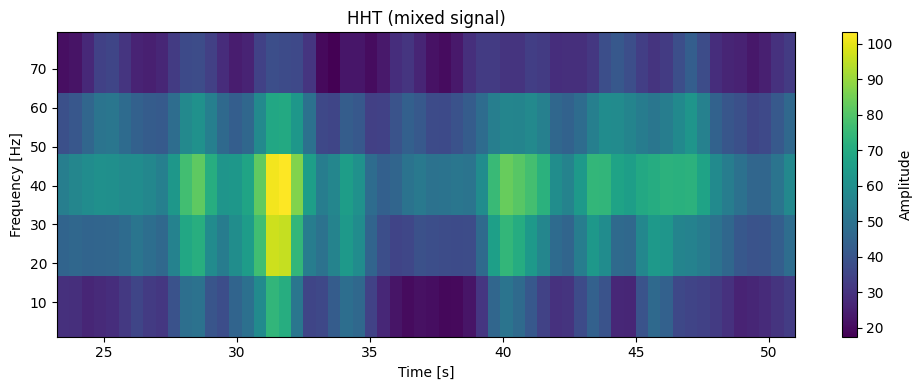

In [31]:
from datasets import UORED
import numpy as np

fs = 42000
duration = 1.0
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

ds = UORED()
s1 = ds.load_file("data/raw/uored/B_11_1.mat")[0][:t.size]
s2 = ds.load_file("data/raw/uored/B_13_1.mat")[0][:t.size]

mixed, pairs, med_if1, med_if2 = superposition(
    s1, s2, fs, t,
    IF_TOL_HZ=200.0,          # tolerância maior para dados reais
    DROP_RESIDUAL=True,
    BAND=None,               # ou ex.: (5.0, 5000.0) se quiser restringir
    MAX_IMFS=5,              # importante para EEMD
    NENSEMBLES=8,            # 4–16 é um bom intervalo inicial
    ENSEMBLE_NOISE=0.2,      # 0.1–0.4 relativo ao std(x)
    NPROCESSES=None,         # ou um inteiro p/ paralelo
    IMF_OPTS=None,
    plot_hht_flag=True
)


## Testando Classificador Binário

In [ ]:
import torch
import numpy as np
from src.models import MCNN_LSTM_Binary

# modelo binário
model = MCNN_LSTM_Binary()

model = MCNN_LSTM_Binary()
model.load_state_dict(torch.load("ckp_bin.pth"))
model.eval()


model.eval()  # modo de avaliação

# batch de exemplo (B=4, L=250 pontos cada amostra)
x = np.load("data/processed/uored_hierarchical/setup_8/test/N_6_0_147.npy")
print(x.shape)
x_tensor = torch.tensor(x, dtype=torch.float32)
print(x_tensor.shape)
x_tensor = x_tensor.unsqueeze(0).unsqueeze(0)
print(x_tensor.shape)

with torch.no_grad():
    logits = model(x_tensor)             # (4,) -> raw scores (logits)
    probs = torch.sigmoid(logits) # (4,) -> [0,1], probabilidade de ser classe 1
    preds = (probs >= 0.5).long() # (4,) -> rótulo binário {0,1}

print("Logits:", logits)
print("Probabilidades:", probs)
print("Predições:", preds)


(1750,)
torch.Size([1750])
torch.Size([1, 1, 1750])
Logits: tensor([1.4246])
Probabilidades: tensor([0.8061])
Predições: tensor([1])


/tmp/ipykernel_3426392/785727376.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ckp_bin.pth"))
